# Inciso 5
Implemente un algoritmo de segmentacion binaria que identifique correctamente todos los granos de arroz en la imagen rice.png. (No se puede aplicar un metodo local).

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

In [6]:
# Cargar la imagen
image_path = os.path.join("images", "rice.jpg")
rice_img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

In [7]:
# Aplicar filtro Gaussiano para suavizar la imagen y reducir ruido
blurred = cv2.GaussianBlur(rice_img, (5,5), 0)

# Aplicar umbralización de Otsu
_, binary = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Aplicar una operación morfológica (apertura) para eliminar ruido
kernel = np.ones((3,3), np.uint8)
processed = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=2)

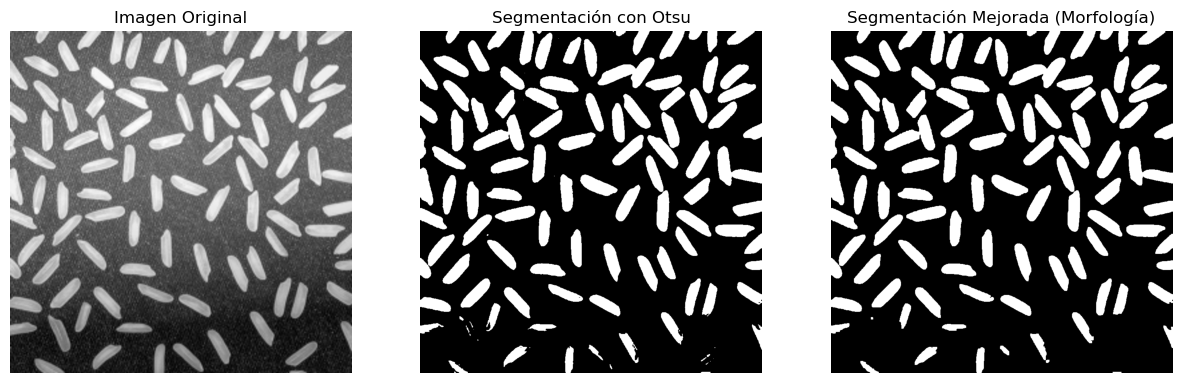

In [8]:
# Mostrar resultados
fig, ax = plt.subplots(1, 3, figsize=(15,5))

ax[0].imshow(rice_img, cmap="gray")
ax[0].set_title("Imagen Original")
ax[0].axis("off")

ax[1].imshow(binary, cmap="gray")
ax[1].set_title("Segmentación con Otsu")
ax[1].axis("off")

ax[2].imshow(processed, cmap="gray")
ax[2].set_title("Segmentación Mejorada (Morfología)")
ax[2].axis("off")

plt.show()

# Analisis de los resultados
## Imagen Original
- Presenta una iluminación no uniforme: los granos de arroz en la parte superior son más claros que los de la parte inferior.
- El fondo también tiene variaciones de intensidad, lo que puede dificultar la segmentación con métodos globales.

## Segmentación con Otsu
- Otsu intenta encontrar un umbral óptimo, pero debido a la variación de iluminación, algunos granos de arroz en la parte inferior no se segmentan correctamente.
- Hay ruido en algunas regiones oscuras donde se observa parte del fondo segmentado incorrectamente.

## Segmentación Mejorada (Morfología)
- Se eliminó una cantidad considerable de ruido con la operación morfológica.
- Sin embargo, todavía hay pequeños fragmentos oscuros en la parte inferior que no se segmentaron bien.
- Algunos granos de arroz pueden estar pegados debido al cierre morfológico.

# Mejoras

In [ ]:
# Aplicar CLAHE para mejorar el contraste
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
enhanced = clahe.apply(rice_img)

# filtro gaussiano
blurred = cv2.GaussianBlur(enhanced, (5,5), 0)

# otsu
_, binary = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# morfologia
kernel = np.ones((3,3), np.uint8)
processed = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=2)

# Crear marcador para Watershed
sure_bg = cv2.dilate(processed, kernel, iterations=3)
dist_transform = cv2.distanceTransform(processed, cv2.DIST_L2, 5)
_, sure_fg = cv2.threshold(dist_transform, 0.5 * dist_transform.max(), 255, 0)
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)

# Etiquetar los objetos
_, markers = cv2.connectedComponents(sure_fg)
markers = markers + 1
markers[unknown == 255] = 0

# Aplicar Watershed
rice_color = cv2.cvtColor(rice_img, cv2.COLOR_GRAY2BGR)
cv2.watershed(rice_color, markers)
rice_color[markers == -1] = [0, 0, 255]  # Bordes en rojo

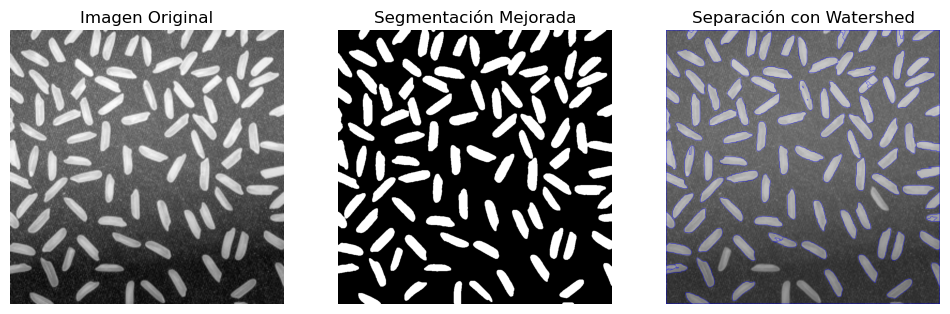

In [10]:
# Mostrar resultados
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].imshow(rice_img, cmap='gray')
ax[0].set_title('Imagen Original')
ax[1].imshow(processed, cmap='gray')
ax[1].set_title('Segmentación Mejorada')
ax[2].imshow(rice_color)
ax[2].set_title('Separación con Watershed')

for a in ax:
    a.axis('off')

plt.show()


# Analisis de los resultados
- Watershed logró separar los granos que estaban pegados, algo que la segmentación con Otsu no podía hacer por sí sola.
- Se observan contornos marcados en azul en la imagen, indicando que los granos que estaban muy juntos han sido correctamente diferenciados.
- Aunque funciona bien, en algunos casos podría correr un riesgo de haber sobresegmentación (separando partes de un mismo grano como si fueran varios).

# Conclusiones
- La mejora en la segmentación permitió identificar con mayor precisión los granos de arroz, incluso en las áreas más oscuras.
- Watershed ayudó a separar granos pegados, mejorando la detección individual de cada elemento.
- La combinación de CLAHE + Otsu + Morfología + Watershed resultó ser una estrategia robusta para la segmentación de esta imagen.